# Symphonypy usage with your own reference

In [1]:
import os
import sys

In [2]:
# %%capture
# !pip install scanpy[leiden] openTSNE
# !pip install --force-reinstall --no-deps git+https://github.com/potulabe/symphonypy.git
# !gdown "1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t"
JUPYTER_DIR = os.path.dirname(os.path.abspath("__file__"))
SYMPHONY_DIR = os.path.dirname(JUPYTER_DIR)
DATA_DIR = os.path.join(os.path.dirname(JUPYTER_DIR), "data")

sys.path.append(SYMPHONY_DIR)
sys.path

import symphonypy as sp

In [3]:
import scanpy as sc

sc.set_figure_params(dpi=150)

adata_ref = sc.read_h5ad("PBMC_Satija.h5ad")
adata_ref = adata_ref[adata_ref.obs.donor == "P1"]
adata_ref.obs.head()

,orig.ident,lane,donor,time,celltype.l1,celltype.l2,celltype.l3,Phase
L1_AAACCCATCTGCGGAC,P1_0,L1,P1,0,CD4 T,CD4 TCM,CD4 TCM_1,S
L1_AAACGAAAGTTACTCG,P1_0,L1,P1,0,CD4 T,CD4 TCM,CD4 TCM_3,G1
L1_AAACGCTAGGTCGTCC,P1_0,L1,P1,0,CD8 T,CD8 TEM,CD8 TEM_2,S
L1_AAAGAACGTATCCTCC,P1_0,L1,P1,0,CD8 T,CD8 Naive,CD8 Naive,S
L1_AAAGAACTCGCTTAAG,P1_0,L1,P1,0,CD4 T,CD4 TCM,CD4 TCM_1,S


Reference preprocessing and preparation for label transfer using Harmony. We recommend using the same normalization factor for reference and query datasets.

In [4]:
sc.pp.normalize_total(adata_ref, target_sum=1e5) # 1e5 will be used for query
sc.pp.log1p(adata_ref)
sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes=3000,
)
adata_ref.raw = adata_ref

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
# adata_ref = adata_ref[:, adata_ref.var.highly_variable]
sc.pp.scale(adata_ref, max_value=10)
sc.pp.pca(adata_ref, n_comps=30)

The following step should be performed with `harmony_integrate` function from Symphonypy package (it appends additional information to AnnData object's `.uns` slot).

In [ ]:
# sp.pp.harmony_integrate(adata_ref, key="orig.ident")

Now let's compute UMAP for futher visualization and its coordinates transfer, and perform clustering with Leiden algorithm.

In [8]:
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)
sc.tl.leiden(adata_ref)

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


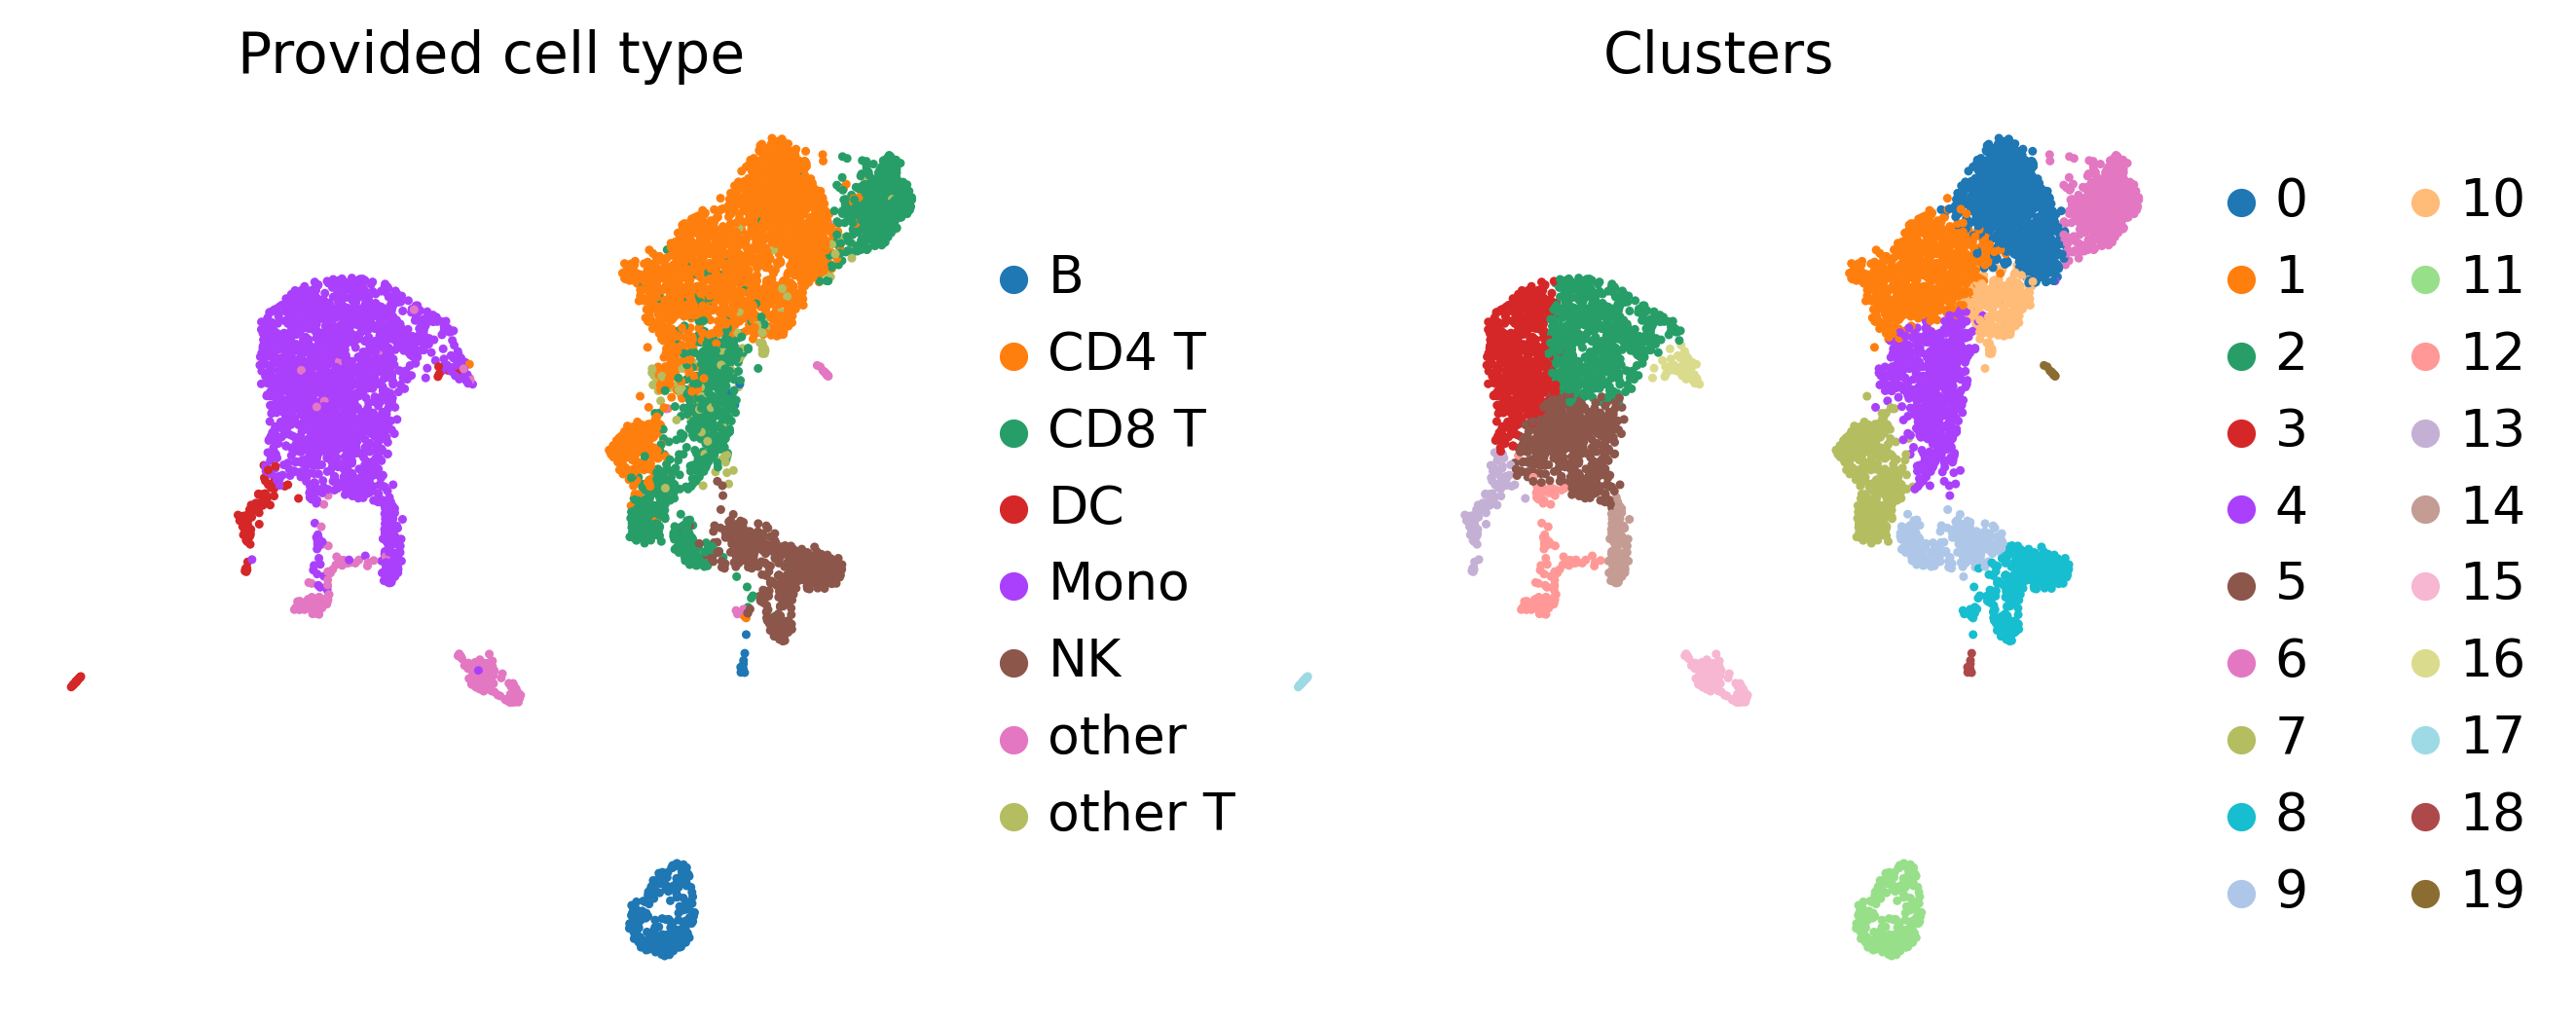

In [9]:
sc.pl.umap(
    adata_ref,
    color=["celltype.l1", "leiden"],
    frameon=False,
    title=["Provided cell type", "Clusters"],
)

## Query mapping and label transfer

In [6]:
adata_query = sc.datasets.pbmc3k()
sc.pp.normalize_total(adata_query, target_sum=1e5)
sc.pp.log1p(adata_query)

In [12]:
import numpy as np

In [9]:
use_genes_column = "highly_variable"
use_genes_list = (
    adata_ref.var_names
    if use_genes_column is None
    else adata_ref.var_names[adata_ref.var[use_genes_column]]
)

In [10]:
%%timeit
use_genes_list_present = use_genes_list.isin(adata_query.var_names)

2.11 ms ± 30.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
use_genes_list_ar = np.array(use_genes_list)
var_names_ar = np.array(adata_query.var_names)

In [14]:
%%timeit
use_genes_list_present = np.isin(use_genes_list_ar, var_names_ar)

1.06 s ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's do embedding mapping and label transfering with symphonypy.

In [11]:
# Mapping Harmony coordinates
sp.tl.map_embedding(
    adata_query=adata_query,
    adata_ref=adata_ref, 
    transferred_primary_basis="X_pca",
    transferred_adjusted_basis="X_pca",
)

/home/ku/projs/symphony/symphonypy/tools.py:224: UserWarning: Not found `harmony` object in adata_ref.uns.
Assuming that adata_ref doesn't have any batches, and using 'X_pca' representation of adata_ref for clustering.
Otherwise, firstly run symphonypy.pp.harmony_integrate on adata_ref to account for them.
  warnings.warn(
541 out of 3000 genes from the reference are missing in the query dataset or have zero std in the reference, their expressions in the query will be set to zero


In [12]:
adata_ref.uns["neighbors"]

OverloadedDict, wrapping:
	{'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'n_neighbors': 15, 'method': 'umap', 'random_state': 0, 'metric': 'euclidean'}}
With overloaded keys:
	['connectivities', 'distances'].

In [13]:
# Mapping UMAP coordinates
sp.tl.ingest(adata_query=adata_query, adata_ref=adata_ref)

/home/ku/projs/symphony/symphonypy/tools.py:140: UserWarning: 'X_pca' representation will be used for neighbors search in adata_query
  warnings.warn(


In [14]:
# Labels prediction
sp.tl.transfer_labels_kNN(
    adata_query=adata_query,
    adata_ref=adata_ref,
    ref_labels=["celltype.l1", "leiden"],
    ref_basis="X_pca",
    query_basis="X_pca",
)

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Reference dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

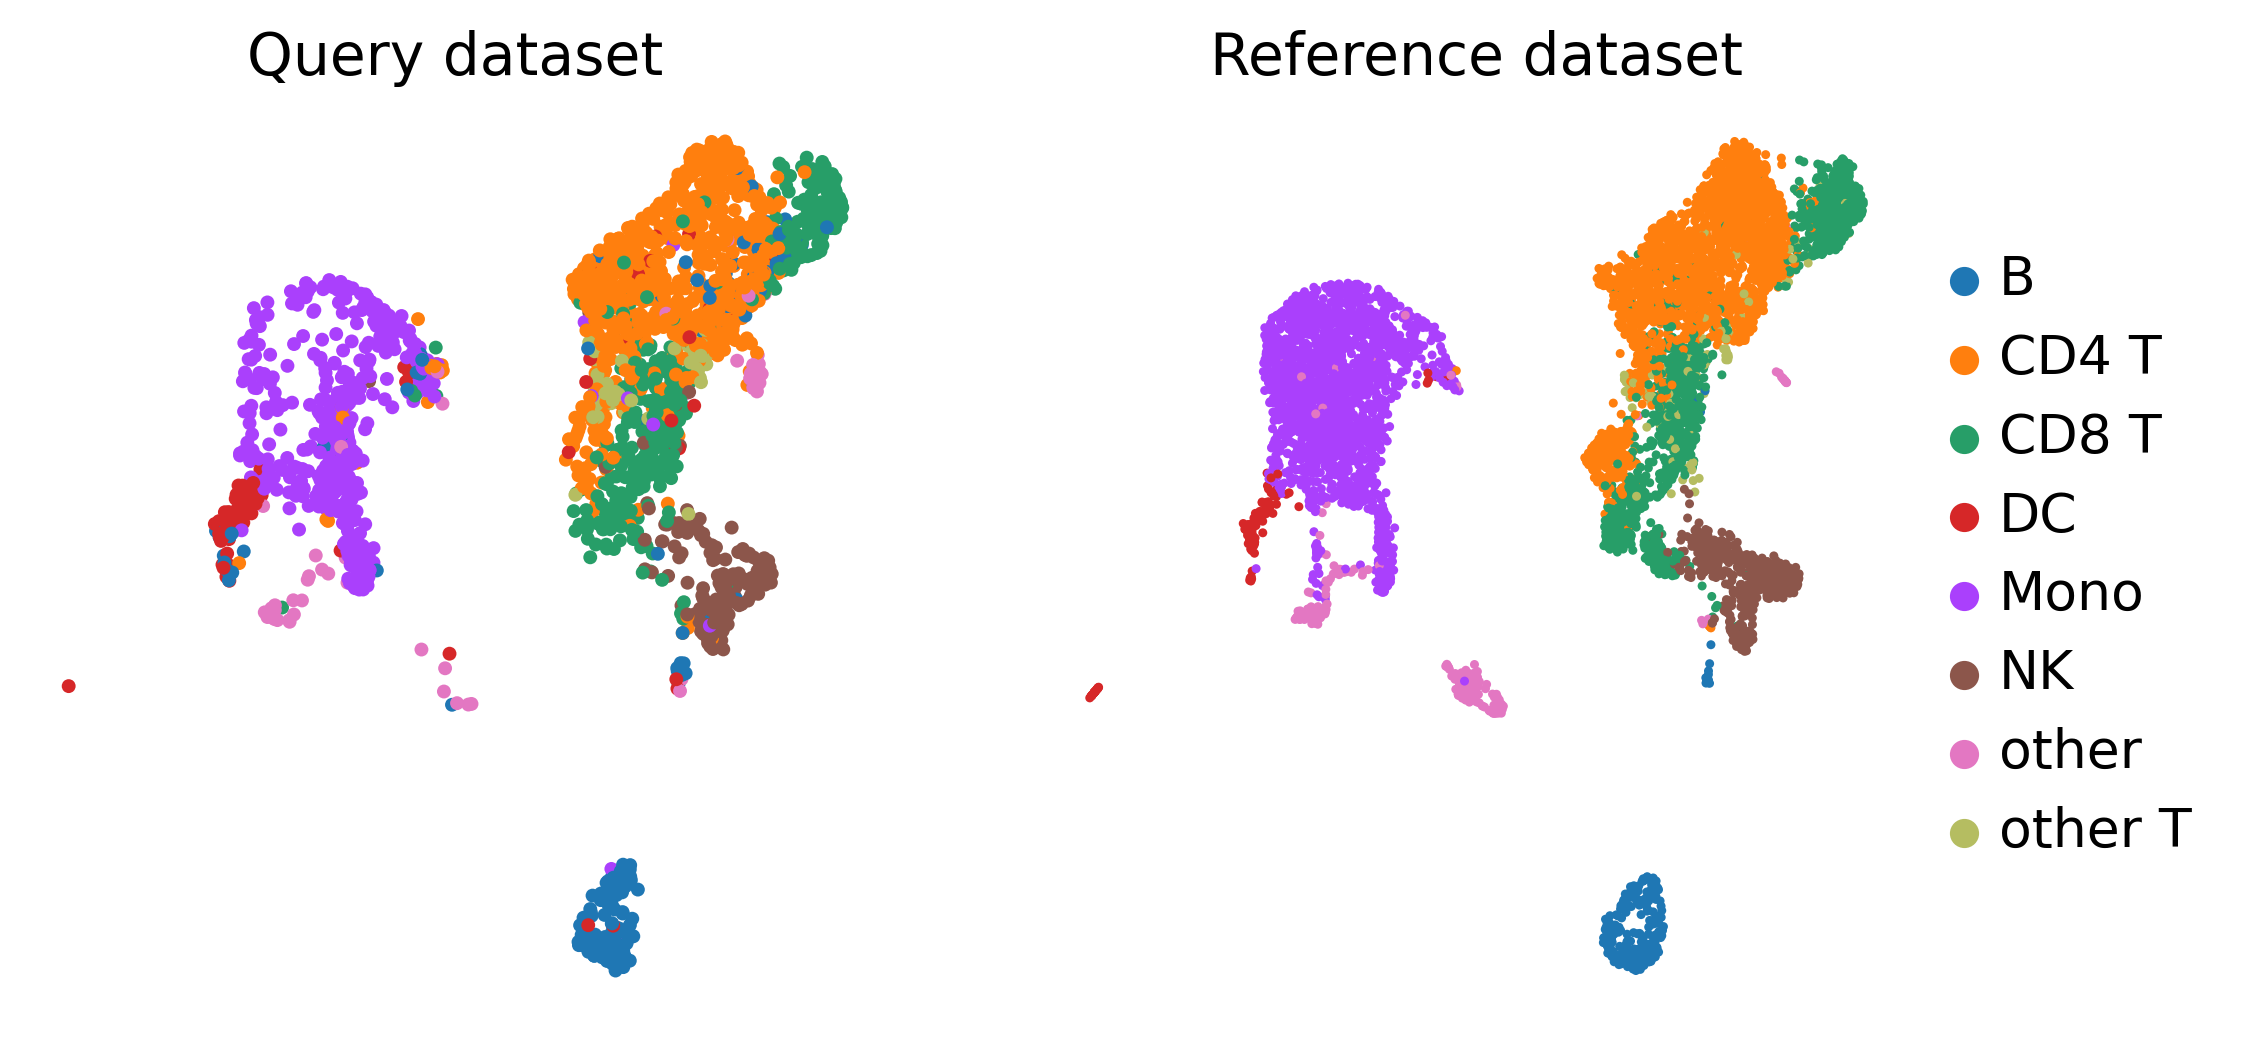

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sc.pl.umap(
    adata_query,
    color="celltype.l1",
    frameon=False,
    title="Query dataset",
    ax=axes[0],
    show=False,
    legend_loc=None,
)

sc.pl.umap(
    adata_ref,
    color="celltype.l1",
    frameon=False,
    title="Reference dataset",
    ax=axes[1],
    show=False,
)
     

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


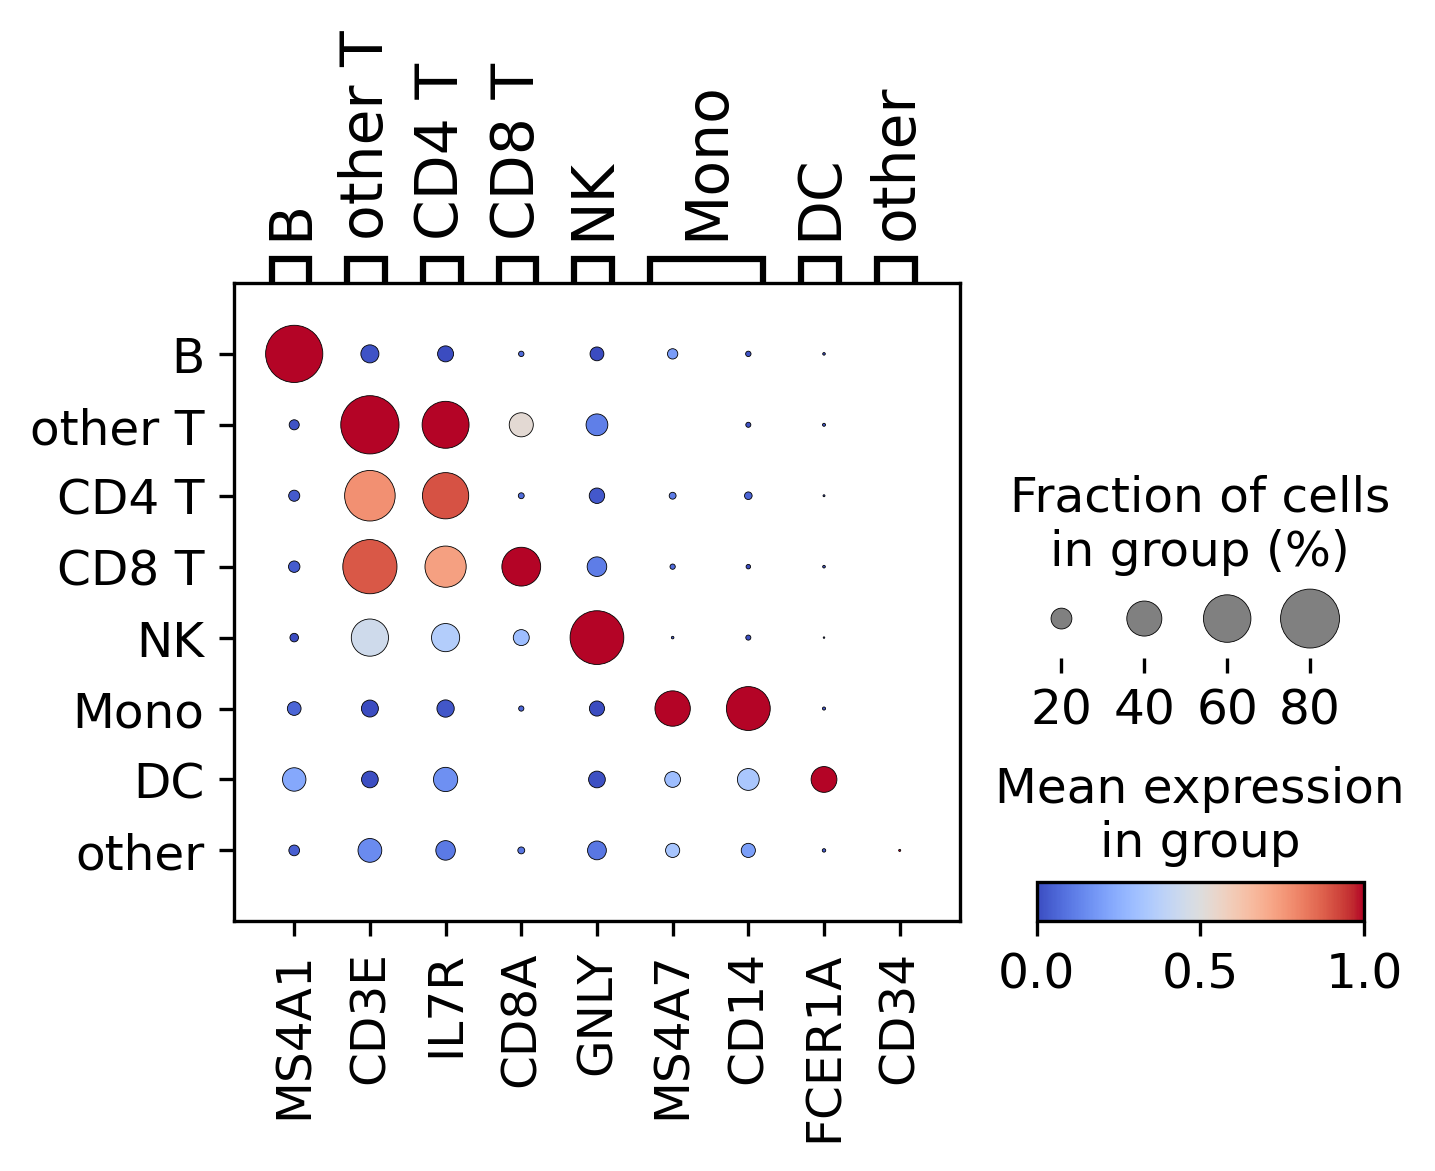

In [16]:
marker_genes = {
    "B": ["MS4A1"],
    "other T": ["CD3E"],
    "CD4 T": ["IL7R"],
    "CD8 T": ["CD8A"],
    "NK": ["GNLY"],
    "Mono": ["MS4A7", "CD14"],
    "DC": ["FCER1A"],
    "other": ["CD34"],
}

adata_query.obs["celltype.l1"] = (
    adata_query.
    obs["celltype.l1"].
    cat.
    reorder_categories(
        list(marker_genes.keys())
    )
)

sc.pl.dotplot(
    adata_query,
    var_names=marker_genes,
    groupby="celltype.l1",
    standard_scale="var",
    dot_max=0.8,
    cmap="coolwarm",
)